In [2]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

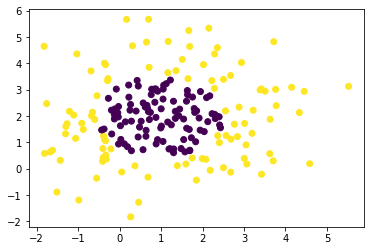

In [4]:
from sklearn.datasets import make_gaussian_quantiles
X, y = make_gaussian_quantiles(n_samples=200, n_features=2, n_classes=2, mean=[1,2],cov=2,random_state=222)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

In [20]:
def update(i,j):
    # 如果i==j,直接返回
    if i == j:
        return
    
    # 保存旧值
    a_i,a_j = alpha[i],alpha[j]
    
    # 计算a_j的上下界
    L = max(0,a_j-a_i) if y[i]!=y[j] else max(0,a_j+a_i-C)
    H = min(C,C+a_j-a_i) if y[i]!=y[j] else min(C,a_i+a_j)
    
    # 计算a_j未经剪辑的值
    a_j_unc = a_j + y[j]*(E(i)-E(j))/(K[i][j]+K[j][j]-2*K[i][j])
    
    # 计算a_j_new,a_i_new
    if a_j_unc < L:
        a_j_new = L
    elif a_j_unc > H:
        a_j_new = H
    else:
        a_j_new = a_j_unc
    a_i_new = a_i + y[i]*y[j]*(a_j-a_j_new)
    
    # 更新a_i和a_j
    alpha[i] = a_i_new
    alpha[j] = a_j_new
    
    # 更新b_new
    b_i_new = y[i] - np.sum(alpha*y*K[i])
    b_j_new = y[j] - np.sum(alpha*y*K[j])
    ## 不管 a_i 和 a_j 怎样，b_new 更新为 b_i_new和b_j_new的一半都是合理的
    b = 0.5*(b_i_new + b_j_new)

In [49]:
def appro_equal(x,y):
    return np.abs(x-y) < 1e-6

In [94]:
class SVM_SMO:
    def __init__(self,C=1,sigma=1,max_iter=100000):
        self.C = C
        self.sigma = sigma
        self.max_iter = max_iter

    def _gaussian(self,x,z):
        return np.exp(-0.5*np.sum((x-z)**2)/(sigma**2))
    
    def _g(self,i):
        return np.sum(self.alpha*self.y*self.K[i])+self.b
    
    def _E(self,i):
        return self._g(i) - self.y[i]
    
    def _KKT(self,i):
        y_g = self._g(i)*self.y[i]
        if appro_equal(self.alpha[i],0):
            return y_g >= 1
        elif 0 < self.alpha[i] < self.C:
            return appro_equal(y_g,1)
        else:
            return y_g <= 1    
    
    def fit(self,X,y):
        self.alpha = np.random.rand(len(y))
        self.b = 0
        self.X = X
        self.y = y
        
        n_samples,n_features = X.shape
        self.K = np.zeros([n_samples,n_samples])
        for i in range(n_samples):
            for j in range(i,n_samples):
                K_ij = gaussian(X[i],X[j])
                self.K[i][j] = K_ij
                self.K[j][i] = K_ij
        
        iter_ = 0
        while iter_ <= self.max_iter:
            for i in range(len(self.alpha)):
                for j in range(i,len(self.alpha)):
                    self.update(i,j)
                    iter_ += 1
    
    def predict(self,X):
        preds = []
        for x in tqdm(X):
            Ks = np.array([self._gaussian(x,self.X[i]) for i in range(len(self.X))])
            pred = np.sum(self.alpha*Ks*self.y)+self.b
            pred = 1 if pred >= 0 else -1
            preds.append(pred)
        return np.array(preds)
    
    def score(self,X,y):
        return np.sum(self.predict(X)==y) / len(y)
    
    
    def update(self,i,j):
        # 如果i==j,直接返回
        if i == j:
            return

        # 保存旧值
        a_i,a_j = self.alpha[i],self.alpha[j]

        # 计算a_j的上下界
        L = max(0,a_j-a_i) if self.y[i]!=self.y[j] else max(0,a_j+a_i-self.C)
        H = min(self.C,self.C+a_j-a_i) if self.y[i]!=self.y[j] else min(self.C,a_i+a_j)

        # 计算a_j未经剪辑的值
        eta = self.K[i][j]+self.K[j][j]-2*self.K[i][j]
        if eta <= 0:
            return
        a_j_unc = a_j + y[j]*(self._E(i)-self._E(j))/eta

        # 计算a_j_new,a_i_new
        if a_j_unc < L:
            a_j_new = L
        elif a_j_unc > H:
            a_j_new = H
        else:
            a_j_new = a_j_unc
        a_i_new = a_i + y[i]*y[j]*(a_j-a_j_new)

        # 更新a_i和a_j
        self.alpha[i] = a_i_new
        self.alpha[j] = a_j_new

        # 更新b_new
        b_i_new = self.y[i] - np.sum(self.alpha*self.y*self.K[i])
        b_j_new = self.y[j] - np.sum(self.alpha*self.y*self.K[j])
        
        ## 不管 a_i 和 a_j 怎样，b_new 更新为 b_i_new和b_j_new的一半都是合理的
        self.b = 0.5*(b_i_new + b_j_new)

In [95]:
svc = SVM_SMO()
svc.fit(X,y)

In [88]:
y[y==0] = -1

In [96]:
svc.score(X,y)

100%|████████████| 200/200 [00:00<00:00, 595.03it/s]


0.99

In [97]:
def plot_clf(X,y,cls):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    points = np.c_[xx.ravel(), yy.ravel()]
    Z = cls.predict(points).reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z)
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

100%|██████| 222300/222300 [06:16<00:00, 590.49it/s]


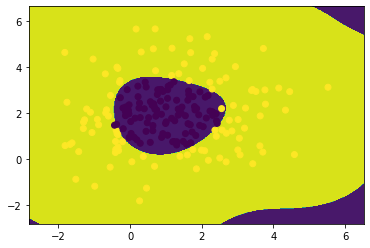

In [98]:
plot_clf(X,y,svc)